In [1]:
from ietfdata.datatracker import *
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import bigbang.analysis.process as process

### Get draft data

First, get the sample drafts for a range of dates.

In [6]:
window = {
    'since' : "2018-01-01T00:00:00",
    'until' : "2018-01-10T00:00:00"
}

In [7]:
dt = DataTracker()

def extract_data(doc):
    data = {}
    ## TODO: Add document UID?
    data['title'] = doc.title
    data['time'] = doc.time
    data['group-acronym'] = dt.group(doc.group).acronym
    data['type'] = doc.type.uri

    affiliations = [
        doc_author.affiliation
        for doc_author
        in dt.document_authors(doc)
    ]
    
    return [
        {**data,
         'affiliation' : affiliation}
        for affiliation
        in affiliations]

drafts = dt.documents(doctype = dt.document_type(
                          DocumentTypeURI("/api/v1/name/doctypename/draft")),
                      **window
                     )

data = [item for sublist in [extract_data(x) for x in drafts] for item in sublist]

INFO:ietfdata:glasgow-ietfdata/0.5.1 (cache disabled)


In [8]:
draft_df = pd.DataFrame(data=data)

In [5]:
draft_df.head()

,title,time,group-acronym,type,affiliation
0,Registry Domain Drop Report,2018-11-29 00:48:59,none,/api/v1/name/doctypename/draft/,
1,The 'Lang' Client Hint,2019-06-02 00:18:22,none,/api/v1/name/doctypename/draft/,Google
2,IS-IS Extensions for Segment Routing,2019-12-06 14:35:53,lsr,/api/v1/name/doctypename/draft/,Huawei
3,IS-IS Extensions for Segment Routing,2019-12-06 14:35:53,lsr,/api/v1/name/doctypename/draft/,"Cisco Systems, Inc."
4,IS-IS Extensions for Segment Routing,2019-12-06 14:35:53,lsr,/api/v1/name/doctypename/draft/,"Cisco Systems, Inc."


Create a table for the group and affiliation links in particular.

In [6]:
link_df = draft_df[['group-acronym', 'affiliation','time']]
link_df[:5]

,group-acronym,affiliation,time
0,none,,2018-11-29 00:48:59
1,none,Google,2019-06-02 00:18:22
2,lsr,Huawei,2019-12-06 14:35:53
3,lsr,"Cisco Systems, Inc.",2019-12-06 14:35:53
4,lsr,"Cisco Systems, Inc.",2019-12-06 14:35:53


### Entity resolution on the affiliations

Using containment distance, collapse the entities in the `affilation` column and removed suspected duplicates.

In [7]:
all_affiliations = link_df.groupby('affiliation').size()

In [8]:
ents = process.resolve_entities(all_affiliations,
                                process.containment_distance,
                                threshold=.25)

replacements = {}
for r in [{name: ent for name in ents[ent]} for ent in ents]:
    replacements.update(r)
    
link_df = link_df.replace(to_replace=replacements)

### Plot the network links between working groups and affiliations

In [9]:
edges = [
 (row[1]['group-acronym'], row[1]['affiliation'])
 for row
 in link_df[['group-acronym','affiliation']].iterrows()
]

In [10]:
G = nx.Graph()

G.add_nodes_from([x[0]
                  for x
                  in link_df[['group-acronym']].drop_duplicates().values],
                 category=0)
G.add_nodes_from(all_affiliations.index,
                 category=1)

G.add_edges_from(edges)

In [11]:
## Clean the graph

G.remove_node('none')

for c in list(nx.connected_components(G)):
    if len(c) <= 1:
        for n in c:
            G.remove_node(n)

In [12]:
colors = ['r' if x[1]['category'] else 'g' for x in list(G.nodes(data=True))]

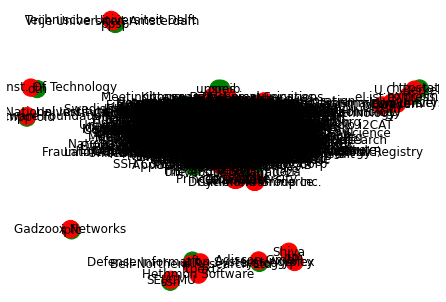

In [13]:
nx.draw(
    G,
    node_color = colors,
    with_labels = True
)

In [14]:
nx.write_gexf(G,"group-affiliations.gexf")

### Look at categories of affiliations

In [39]:
cat = pd.read_csv("../organizations/organization_categories.csv")

In [40]:
replacements = {x[1]['name'] : x[1]['category']
                for x
                in cat.iterrows()
                if not pd.isna(x[1]['category'])}

In [41]:
link_cat_df = link_df.replace(to_replace=replacements)

In [49]:
link_cat_df.groupby('affiliation').size().sort_values(ascending=False)[:40]

affiliation
Networking equipment vendor              4025
                                          721
Telecommunications Provider               482
Google                                    236
Consumer hardware and software vendor     160
Research Institution                      129
Alcatel-Lucent                            124
China Mobile                              123
Internet Registry                         122
Content Distribution Network              105
Apple Inc.                                 92
ZTE Corporation                            84
Independent                                83
VeriSign, Inc.                             73
Oracle                                     68
Comcast                                    67
Old Dog Consulting                         60
Individual                                 58
InterDigital Communications, LLC           56
Arrcus, Inc.                               53
Qualcomm                                   52
Software provider     

In [42]:
edges = [
 (row[1]['group-acronym'], row[1]['affiliation'])
 for row
 in link_cat_df[['group-acronym','affiliation']].iterrows()
]

affils = link_cat_df.groupby('affiliation').size().index

In [43]:
G = nx.Graph()

G.add_nodes_from([x[0]
                  for x
                  in link_cat_df[['group-acronym']].drop_duplicates().values],
                 category=0)
G.add_nodes_from(affils,
                 category=1)

G.add_edges_from(edges)

In [44]:
## Clean the graph

G.remove_node('none')

for c in list(nx.connected_components(G)):
    if len(c) <= 1:
        for n in c:
            G.remove_node(n)

In [45]:
[x[1] for x in list(G.nodes(data=True)) if 'category' not in x[1]]

[]

In [46]:
colors = ['r' if x[1]['category'] else 'g' for x in list(G.nodes(data=True))]

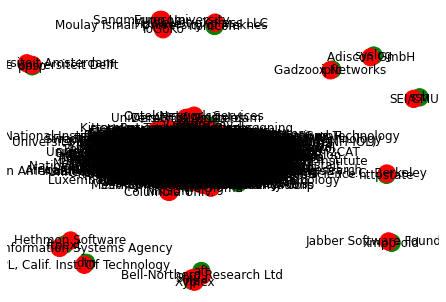

In [47]:
nx.draw(
    G,
    node_color = colors,
    with_labels = True
)

In [48]:
nx.write_gexf(G,"group-org-categories.gexf")